# MiniDiffusion

## Project Setup

### Notebook Setup Instructions

Ensure the following prerequisites are installed and configured:

1. **PyTorch Installation**  
   **Version Used:** PyTorch 2.5.1  
   Install PyTorch according to your system specifications:  
   Refer to the official guide: [https://pytorch.org/get-started/locally/](https://pytorch.org/get-started/locally/)

2. **CUDA Compatibility**  
    **Version Required:** CUDA 12.4  
    Ensure your system has compatible GPU drivers installed.  
    Download and install CUDA: [CUDA 12.4 Download](https://developer.nvidia.com/cuda-12-4-0-download-archive)

4. **Python Version**  
    **Version Required:** Python 3.12.8  
    Download and install Python: [Download Python 3.12.8](https://www.python.org/downloads/release/python-3128/)

5. **Rust Installation**  
    Rust is required for certain dependencies.  
    Download and install Rust: [rustup](https://rustup.rs/)


### Install Required Dependencies

Install necessary Python packages.


In [1]:
# Check if the variable `dependencies_installed` exists and is True
if not globals().get("dependencies_installed", False):
    # Install the required packages
    %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
    %pip install --upgrade diffusers accelerate transformers
    %pip install pillow
    %pip install ipywidgets tqdm --upgrade

    # Install PEFT for LoRA integration
    %pip install peft
    
    # Set the flag to True after successful installation
    dependencies_installed = True
    print("Dependencies installed successfully.")
else:
    print("Dependencies are already installed, skipping installation.")


Looking in indexes: https://download.pytorch.org/whl/cu124Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Dependencies installed successfully.


### Import Libraries and Modules

Imports necessary libraries and modules for the MiniDiffusion project.


In [2]:
# Check if the variable `modules_imported` exists and is True
if not globals().get("modules_imported", False):
    # Import the required modules
    import os
    import torch
    from diffusers import (
        DiffusionPipeline, StableDiffusionXLPipeline,
        AutoencoderKL, UNet2DConditionModel, 
        EulerAncestralDiscreteScheduler, UniPCMultistepScheduler
    )
    from diffusers.utils import make_image_grid
    from transformers import CLIPTextModel, CLIPTokenizer
    from tqdm import tqdm
    from PIL import Image

    # Set the flag to True after successful imports
    modules_imported = True
    print("Modules imported successfully.")
else:
    print("Modules are already imported, skipping import.")


Modules imported successfully.


### Directory Structure

Ensure the following directories exist or are created.

In [3]:
# Set directories for project
assets_dir = "./assets"
images_path = "./images"

# Define directories
cache_dir = os.path.join(assets_dir, "cache")
models_dir = os.path.join(assets_dir, "models")
loras_dir = os.path.join(assets_dir, "loras")

# Ensure all directories exist
os.makedirs(assets_dir, exist_ok=True)
os.makedirs(images_path, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)


### Default Parameters

In [4]:
# Prepare the prompt and other parameters
prompt = "portrait photo of an old warrior chief"
scheduler_class = EulerAncestralDiscreteScheduler
torch_dtype = torch.float16


### Utility Functions

Define helper functions to streamline common tasks.


In [5]:
def generate_images(prompt, batch_size=1, seed=None, rows=None, cols=None, save_path=None, clear_cache=True, folder_path=images_path, **kwargs):
    """
    Generate single or batch images using a diffusion pipeline and optionally save them.

    Parameters:
        - prompt (str): The prompt to guide the image generation.
        - batch_size (int): Number of images to generate in a batch (default: 1).
        - seed (int, optional): Random seed for reproducibility.
        - rows (int, optional): Number of rows in the image grid (only for batch generation).
        - cols (int, optional): Number of columns in the image grid (only for batch generation).
        - save_path (str, optional): The path to save the generated image(s). If None, no saving occurs.
        - clear_cache (bool, optional): If True, clears GPU cache after generation.
        - folder_path (str, optional): Directory to save the images (default: "images").
        - **kwargs: Additional parameters to pass to the pipeline.

    Returns:
        - output: Generated image(s) as a single or a grid (PIL.Image.Image). 
    """
    # Get input parameters and generate images from the pipeline
    inputs = get_inputs(prompt=prompt, batch_size=batch_size, seed=seed, **kwargs)
    images = pipeline(**inputs).images

    # Automatically calculate rows and cols if they are not provided
    if rows is None or cols is None:
        # Calculate the number of rows and columns for batch generation
        rows = int(batch_size ** 0.5)
        cols = -(-batch_size // rows)

    # Create a grid of the images
    output = make_image_grid(images, rows=rows, cols=cols)

    # Save the generated image(s) if save_path is provided
    if save_path:
        save_image(output, save_path, folder_path)

    # Clear GPU memory cache
    if clear_cache:
        torch.cuda.empty_cache()

    return output

def get_inputs(prompt, batch_size=1, model_type=None, device=None, seed=None, **kwargs):
    """
    Generate input parameters for the diffusion pipeline with default parameters .

    Args:
        - prompt (str): The prompt to guide the image generation.
        - batch_size (int): The number of images to generate in a single batch. Default is 1.
        - model_type (str, optional): Type of model. Options are 'SD' (Stable Diffusion) or 'SDXL' (Stable Diffusion XL).
        - device (torch.device, optional): The device to use ('cuda' or 'cpu'). Defaults to 'cuda' if available.
        - seed (int, optional): The seed value for reproducibility. If None, a random seed is used for each batch item.
        - **kwargs: Additional parameters to override defaults, such as guidance_scale.
        
    Returns:
        - dict: A dictionary containing the inputs for the pipeline.
    """
    if not prompt:
        raise ValueError("Prompt cannot be empty. Please provide a valid prompt.")

    # Set device
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set default inference steps based on model type
    if model_type is None:
        num_inference_steps = kwargs.get("num_inference_steps", 10)
    elif model_type == 'SD':
        num_inference_steps = kwargs.get("num_inference_steps", 20)
    elif model_type == 'SDXL':
        num_inference_steps = kwargs.get("num_inference_steps", 50)
    else:
        raise ValueError("Invalid model_type. Choose either 'SD' or 'SDXL'.")

    # Use provided seed or generate one if not specified
    if seed is None:
        seed = torch.randint(0, 2**32, (1,)).item()  # Random seed if none provided

    # Create the generator based on the seed
    generator = [torch.Generator(device).manual_seed(seed + i) for i in range(batch_size)]

    # Replicate the prompt for the batch size
    prompts = batch_size * [prompt]

    # Prepare the input dictionary
    inputs = {
        "prompt": prompts,
        "generator": generator,
        "num_inference_steps": num_inference_steps,
        **kwargs  # Allow additional arguments
    }

    return inputs

def save_image(image, filename, folder_path=images_path):
    """
    Saves an image to the specified folder with a given filename.
    
    Parameters:
        - image (PIL.Image): The image object to save.
        - filename (str): The name of the image file (e.g., 'output.png').
        - folder_path (str): The directory to save the image in.
    
    Returns:
        - str: The full path to the saved image.
    """
    if not isinstance(filename, str) or not filename.endswith(('.png', '.jpg', '.jpeg')):
        raise ValueError("Filename must be a valid image file with a .png, .jpg, or .jpeg extension.")

    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    
    # Construct the full image path
    image_path = os.path.join(folder_path, filename)
    
    # Save the image
    image.save(image_path)
    print(f"Image saved to: {image_path}")

    return image_path


In [6]:
def load_model(model_class, pretrained_model_path, pretrained_model_name, cache_dir, description, torch_dtype=None, device=None, subfolder=None):
    """
    Load a model from a local path or download it from the Hugging Face Hub.

    Args:
        - model_class (class): The class of the model to load (e.g., AutoencoderKL, DiffusionPipeline).
        - pretrained_model_path (str): The local path to the model.
        - pretrained_model_name (str): The name of the model on the Hugging Face Hub.
        - cache_dir (str): Directory to cache the downloaded model files.
        - description (str): A short description of the model being loaded, used for log messages.
        - torch_dtype (torch.dtype): The PyTorch data type to load the model with (e.g., torch.float16).
        - device (str): The device to load the model onto (e.g., 'cuda' or 'cpu').
        - subfolder (str): The subfolder within the repository where the model component is stored.

    Returns:
        - model: The loaded model, either from the local path or the Hugging Face Hub.
    """
    # Prepare arguments for from_pretrained
    kwargs = {}
    
    # Add torch_dtype if applicable
    if torch_dtype:
        kwargs['torch_dtype'] = torch_dtype

    if os.path.exists(pretrained_model_path):
        print(f"Loading {description} from local path: {pretrained_model_path}...")
        model = model_class.from_pretrained(
            pretrained_model_path,
            **kwargs
        )
    else:
        # Add subfolder if applicable
        if subfolder:
            kwargs['subfolder'] = subfolder

        print(f"Downloading {description} from Hugging Face Hub: {pretrained_model_name} (subfolder: {subfolder})...")
        model = model_class.from_pretrained(
            pretrained_model_name, 
            cache_dir=cache_dir,
            **kwargs
        )
        
        # Save the model locally for future use
        model.save_pretrained(pretrained_model_path)
        print(f"{description} downloaded and saved to {pretrained_model_path}.")

    # Move the model to the specified device if applicable
    if hasattr(model, "to") and device is not None:
        model = model.to(device)
    
    return model

def load_and_configure_models(model_definitions, scheduler_class=None, device=None, force_reload=False, load_model_fn=load_model):
    """
    Load or reload models as needed and configure the pipeline.

    Args:
        - model_definitions (dict): A dictionary defining the models to load.
            - "key" (str): The variable name in the current scope (e.g., 'pipeline', 'vae').
            - "model_class" (class): The class of the model to load.
            - "pretrained_model_name" (str): Hugging Face Hub name of the model.
            - "models_dir" (str): Directory to store or find the models locally.
            - "cache_dir" (str): Directory to cache downloaded models.
            - "torch_dtype" (torch.dtype): PyTorch data type to load the model with.
            - "description" (str): Description of the model.
            - "subfolder" (bool or str, optional): If True, uses the key name as the subfolder. If a string, uses the string. If False or None, no subfolder is used.
        - scheduler_class (class, optional): A custom scheduler class to construct from pipeline configuration.
        - device (str, optional): Device for loading models (default: 'cuda' if available, else 'cpu').
        - force_reload (bool, optional): Whether to force reloading of all models.
        - load_model_fn (function, optional): The function used to load models (default: load_model).

    Returns:
        - dict: Loaded models with updated values in the format {key: loaded_model}.
    """
    # Set the device dynamically if not provided
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    models = {}
    for key, definition in model_definitions.items():
        # Unpack model definition
        model_class = definition.get("model_class")
        pretrained_model_name = definition.get("pretrained_model_name")
        models_dir = definition.get("models_dir", "./assets/models")
        cache_dir = definition.get("cache_dir", "./assets/cache")
        torch_dtype = definition.get("torch_dtype", None)
        description = definition.get("description", key)
        subfolder = definition.get("subfolder", False)

        # Determine the subfolder path
        if isinstance(subfolder, bool) and subfolder:
            subfolder_path = key  # Use the key name if subfolder is True
        elif isinstance(subfolder, str):
            subfolder_path = subfolder  # Use the provided string
        else:
            subfolder_path = None  # No subfolder

        # Construct the local path for the model
        pretrained_model_path = os.path.join(models_dir, pretrained_model_name)
        if subfolder_path:
            pretrained_model_path = os.path.join(pretrained_model_path, subfolder_path)

        # Reload model if force_reload is True or model is None
        models[key] = None if force_reload else locals().get(key, None)
        models[key] = models[key] or load_model_fn(
            model_class=model_class,
            pretrained_model_name=pretrained_model_name,
            pretrained_model_path=pretrained_model_path,
            cache_dir=cache_dir,
            torch_dtype=torch_dtype,
            device=device,
            description=description,
            subfolder=subfolder,
        )

    # Configure pipeline-specific settings if applicable
    if "pipeline" in models:
        pipeline = models["pipeline"]
        if "vae" in models:
            pipeline.vae = models["vae"]
        if "text_encoder" in models:
            pipeline.text_encoder = models["text_encoder"]
        if "tokenizer" in models:
            pipeline.tokenizer = models["tokenizer"]
        if "unet" in models:
            pipeline.unet = models["unet"]
        if "scheduler" in models:
            pipeline.scheduler = models["scheduler"]
        elif scheduler_class:
            pipeline.scheduler = scheduler_class.from_config(pipeline.scheduler.config)
    
    print("All models loaded and configured successfully.")
    return models


## Using a Pipeline

### Model Loading

Load the Diffusion Pipeline and VAE models.


In [7]:
# Model definitions
model_definitions = {
    "pipeline": {
        "model_class": DiffusionPipeline,
        "pretrained_model_name": "stable-diffusion-v1-5/stable-diffusion-v1-5",
        "torch_dtype": torch_dtype,
        "description": "Diffusion pipeline",
    },
    "vae": {
        "model_class": AutoencoderKL,
        "pretrained_model_name": "stabilityai/sd-vae-ft-mse",
        "models_dir": models_dir,
        "cache_dir": cache_dir,
        "torch_dtype": torch_dtype,
        "description": "VAE model",
        "subfolder": True
    },
}

# Load and configure models
models = load_and_configure_models(model_definitions, scheduler_class=scheduler_class)
pipeline = models["pipeline"]
vae = models["vae"]


Loading Diffusion pipeline from local path: ./assets/models\stable-diffusion-v1-5/stable-diffusion-v1-5...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading VAE model from local path: ./assets\models\stabilityai/sd-vae-ft-mse\vae...
All models loaded and configured successfully.


### Image Generation

Generate and save images.


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved to: ./images\single_output.png


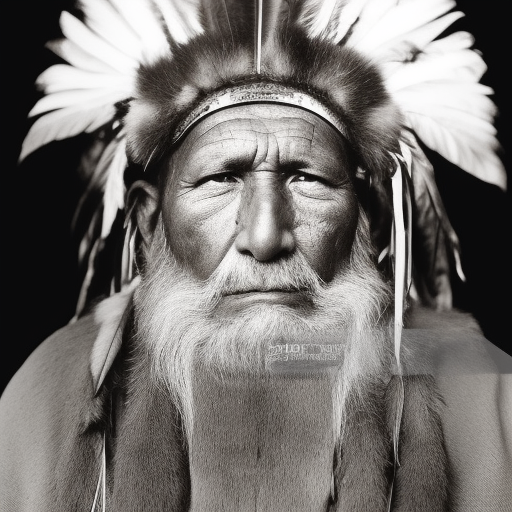

In [8]:
# Single image generation
image = generate_images(
    prompt=prompt,
    seed=0,
    num_inference_steps=20,
    save_path="single_output.png"
)
image


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved to: ./images\batch_output.png


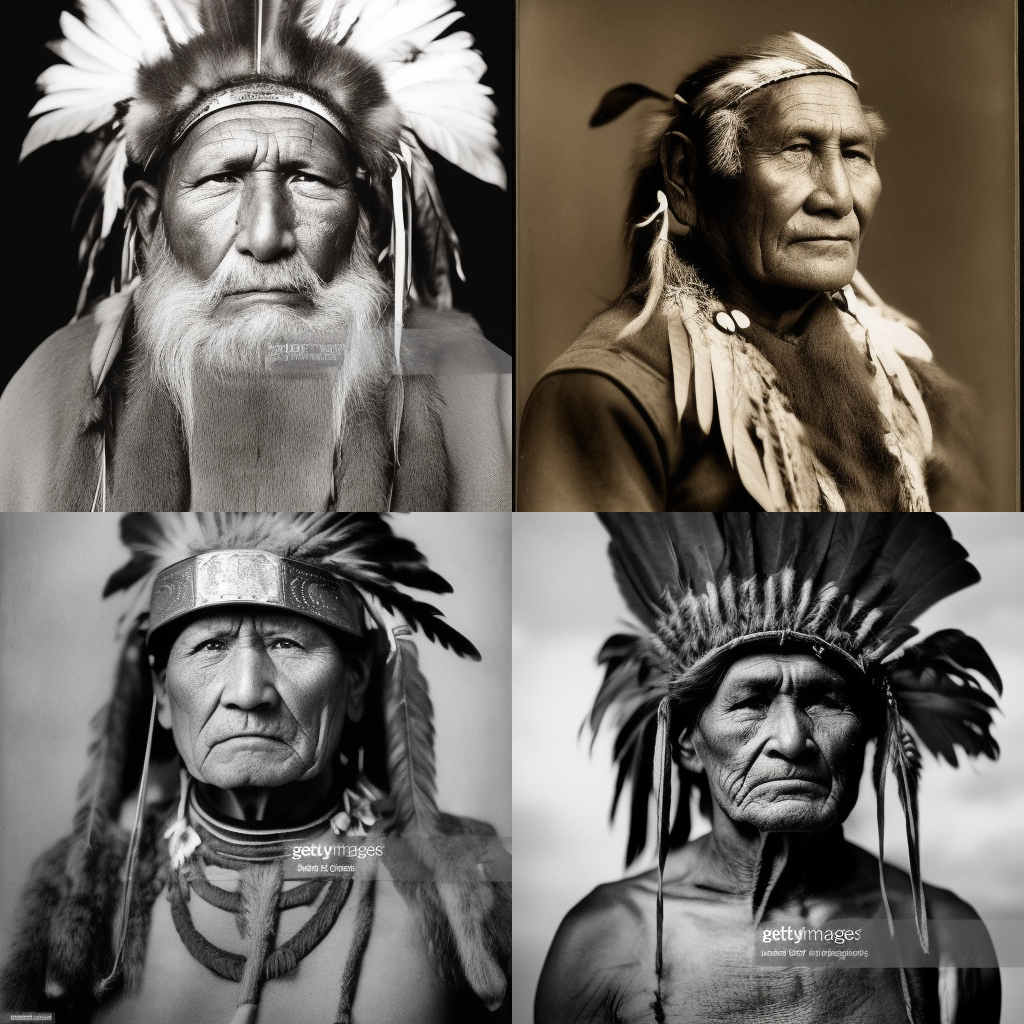

In [9]:
# Batch image generation
grid_image = generate_images(
    prompt=prompt,
    seed=0,
    num_inference_steps=20,
    save_path="batch_output.png",
    batch_size=4,
)
grid_image


## Without a Pipeline

### Scheduler Properties

In this section, we explore some of the properties of the diffusion pipeline scheduler.


In [10]:
# Explore the scheduler properties of the pipeline

# List compatible schedulers available in the pipeline
scheduler_classes = [cls.__name__ for cls in pipeline.scheduler.compatibles]
print("Compatible schedulers:\n", scheduler_classes)

# Check the timesteps of the scheduler
print("\nScheduler timesteps:\n", pipeline.scheduler.timesteps)


Compatible schedulers:
 ['DPMSolverSDEScheduler', 'EulerDiscreteScheduler', 'EulerAncestralDiscreteScheduler', 'DPMSolverMultistepScheduler', 'DDPMScheduler', 'HeunDiscreteScheduler', 'DPMSolverSinglestepScheduler', 'DEISMultistepScheduler', 'LMSDiscreteScheduler', 'DDIMScheduler', 'KDPM2DiscreteScheduler', 'UniPCMultistepScheduler', 'KDPM2AncestralDiscreteScheduler', 'EDMEulerScheduler', 'PNDMScheduler']

Scheduler timesteps:
 tensor([951., 901., 851., 801., 751., 701., 651., 601., 551., 501., 451., 401.,
        351., 301., 251., 201., 151., 101.,  51.,   1.], device='cuda:0')


### Initialize Pretrained Models

In [11]:
# Define model definitions
pretrained_model_name = "CompVis/stable-diffusion-v1-4"
model_definitions = {
    "vae": {
        "model_class": AutoencoderKL,
        "pretrained_model_name": pretrained_model_name,
        "subfolder": True,
    },
    "text_encoder": {
        "model_class": CLIPTextModel,
        "pretrained_model_name": pretrained_model_name,
        "subfolder": True,
    },
    "unet": {
        "model_class": UNet2DConditionModel,
        "pretrained_model_name": pretrained_model_name,
        "subfolder": True,
    },
    "tokenizer": {
        "model_class": CLIPTokenizer,
        "pretrained_model_name": pretrained_model_name,
        "subfolder": True,
    },
    "scheduler": {
        "model_class": UniPCMultistepScheduler,
        "pretrained_model_name": pretrained_model_name,
        "subfolder": True,
    },
}

# Load models using the centralized function
models = load_and_configure_models(model_definitions)

# Extract individual components (optional)
vae = models["vae"]
text_encoder = models["text_encoder"]
unet = models["unet"]
tokenizer = models["tokenizer"]
scheduler = models["scheduler"]


Loading vae from local path: ./assets/models\CompVis/stable-diffusion-v1-4\vae...
Loading text_encoder from local path: ./assets/models\CompVis/stable-diffusion-v1-4\text_encoder...
Loading unet from local path: ./assets/models\CompVis/stable-diffusion-v1-4\unet...
Loading tokenizer from local path: ./assets/models\CompVis/stable-diffusion-v1-4\tokenizer...
Loading scheduler from local path: ./assets/models\CompVis/stable-diffusion-v1-4\scheduler...
All models loaded and configured successfully.


### Define Parameters

In [12]:
# Define generation parameters
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


### Tokenize Input Prompt

In [13]:
# Tokenize the text input
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

# Get text embeddings
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

# Prepare unconditional embeddings for classifier-free guidance
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

# Combine unconditional and conditional embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


### Initialize Latents

In [14]:
# Initialize random latent noise
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
).to(device)
latents = latents * scheduler.init_noise_sigma


### Denoising Loop

In [15]:
# Set scheduler timesteps
scheduler.set_timesteps(num_inference_steps)

# Denoising loop
for t in tqdm(scheduler.timesteps):
    # Expand latents for classifier-free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Scale the model input
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform classifier-free guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Update latents (Compute the previous noisy sample x_t -> x_t-1)
    latents = scheduler.step(noise_pred, t, latents).prev_sample



00%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.99it/s]

### Decode Latents to Image

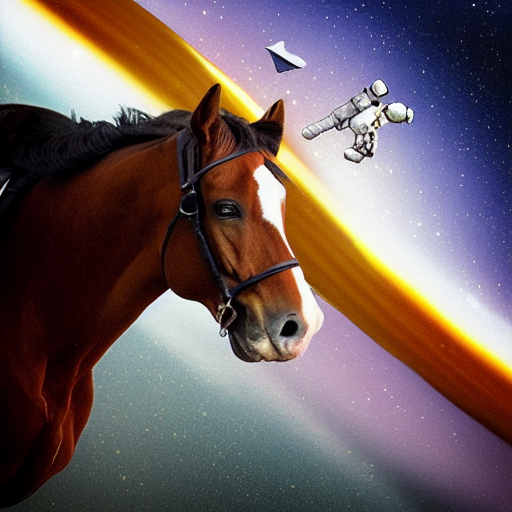

In [16]:
# Scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Post-process the image
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)

# Display the final image
image


## LoRA

### Model Loading

In [17]:
# Define model definitions
model_definitions = {
    "pipeline": {
        "model_class": StableDiffusionXLPipeline,
        "pretrained_model_name": "Linaqruf/animagine-xl",
        "torch_dtype": torch_dtype,
    },
}

# Configurations parameters
scheduler_class = EulerAncestralDiscreteScheduler

# Load and configure models
models = load_and_configure_models(model_definitions, scheduler_class=scheduler_class)
pipeline = models["pipeline"]

# Load LoRA
lora_model_id = "Linaqruf/pastel-anime-xl-lora"
lora_filename = "pastel-anime-xl.safetensors"
pipeline.lora_state_dict(lora_model_id, weight_name=lora_filename, adapter_name="anime_pastel")

lora_model_id = "artificialguybr/LineAniRedmond-LinearMangaSDXL-V2"
lora_filename = "LineAniRedmondV2-Lineart-LineAniAF.safetensors"
pipeline.load_lora_weights(lora_model_id, weight_name=lora_filename, adapter_name="anime_lineart")


Loading pipeline from local path: ./assets/models\Linaqruf/animagine-xl...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

All models loaded and configured successfully.


In [18]:
# Default inputs
inputs = {
    "prompt": "face focus, cute, masterpiece, best quality, 1girl, sweater, looking at viewer, upper body, beanie, outdoors, night, turtleneck",
    "negative_prompt": "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry",
    "seed": 0,
    "width": 1024,
    "height": 1024,
    "guidance_scale": 12,
    "target_size": (1024, 1024),
    "original_size": (4096, 4096),
    "num_inference_steps": 50,
}


### Example without LoRA

In [19]:
# Disable LoRA
pipeline.disable_lora()


In [20]:
# Generate without LoRA
images = generate_images(
    **inputs, model_type="SDXL",
    save_path="anime_no_lora.png",
    batch_size=4
)
images

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Example with LoRA

In [ ]:
# Enable LoRA
pipeline.enable_lora()


In [ ]:
# Generate with LoRA
images = generate_images(
    **inputs, model_type="SDXL",
    save_path="anime_lora.png",
    batch_size=4
)
images